## 1. Import Libraries and Constants

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from storesales.constants import EXTERNAL_TRAIN_PATH

## 2. Load Data
### Load Sales Data

In [95]:
df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])

### Ensure Daily Sales Data

In [96]:
multi_idx = pd.MultiIndex.from_product(
    [
        pd.date_range(df["date"].min(), df["date"].max()),
        df.store_nbr.unique(),
        df.family.unique(),
    ],
    names=["date", "store_nbr", "family"],
)
train = df.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.0)
train.id = train.id.interpolate(method="linear")

In [16]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## 3. Select Family && Explore Sales

In [97]:
FAMILY = "BEVERAGES"
explore_store_nbrs = [18, 20]

df_beverages = df[df["family"] == FAMILY]

In [98]:
def plot_sales(data_df: pd.DataFrame) -> None:
    for store_nbr, group in data_df.groupby("store_nbr"):
        plt.figure(figsize=(12, 4))
        plt.plot(group["date"], group["sales"])
        plt.title(f"Store {store_nbr}")
        plt.show()

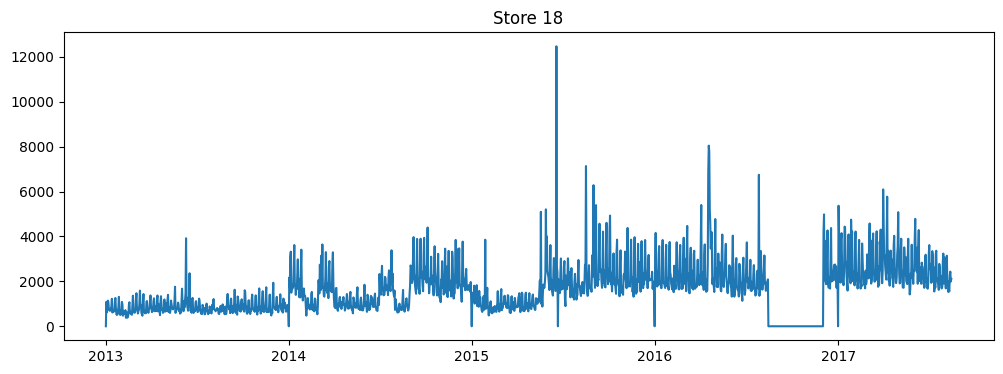

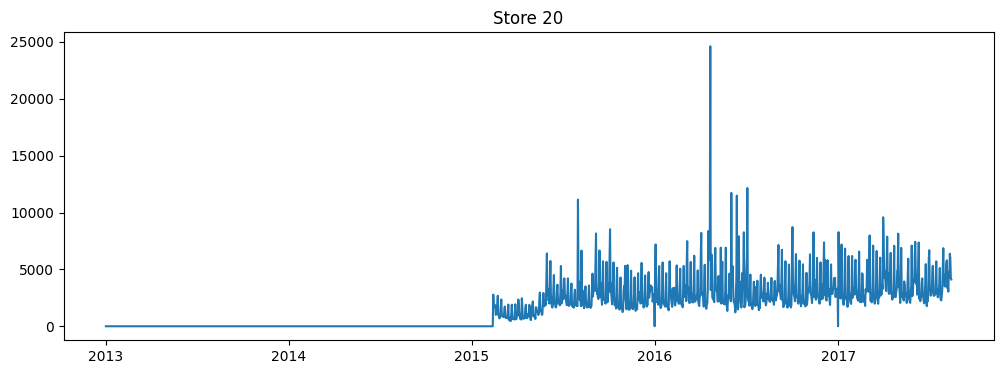

In [99]:
exploration_df = df_beverages[df_beverages["store_nbr"].isin(explore_store_nbrs)]

plot_sales(exploration_df)

* Store 18 has zero-sales gap between 2016 and 2017;
* Store 20 starts with zero-sales sequence;

## 4. Data Cleaning

In [100]:
def remove_leading_zeros(group: pd.DataFrame) -> pd.DataFrame:
    group = group.sort_values("date").reset_index(drop=True)
    group = group.loc[group["sales"].ne(0).idxmax() :]
    return group


def replace_zero_gaps(group: pd.DataFrame, n: int) -> pd.DataFrame:
    # Replace zeros with None where gap size is greater than `n`

    zero_gap = group["sales"] == 0
    zero_shift_series = pd.Series(zero_gap != zero_gap.shift())
    gap_size = zero_gap.groupby(zero_shift_series.cumsum()).transform("sum")

    group.loc[zero_gap & (gap_size > n), "sales"] = None
    return group

### Remove Leading Zeros

In [101]:
df_beverages_cleaned = df_beverages.groupby(["store_nbr", "family"]).apply(
    remove_leading_zeros, include_groups=False
)
df_beverages_cleaned = df_beverages_cleaned.reset_index(level=["store_nbr", "family"])

### Replace Zero Gaps

In [102]:
gap_size_to_replace = 10

In [103]:
df_beverages_cleaned_no_gaps = df_beverages_cleaned.groupby(
    ["store_nbr", "family"]
).apply(replace_zero_gaps, n=gap_size_to_replace, include_groups=False)
df_beverages_cleaned_no_gaps = df_beverages_cleaned_no_gaps.reset_index(
    level=["store_nbr", "family"]
)

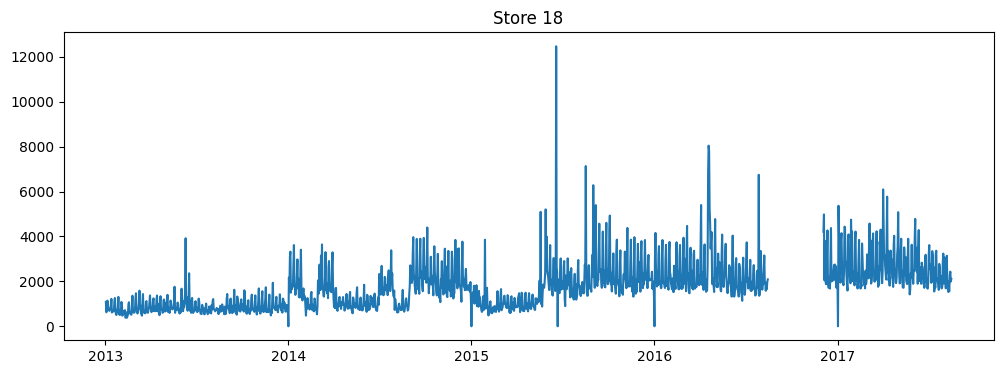

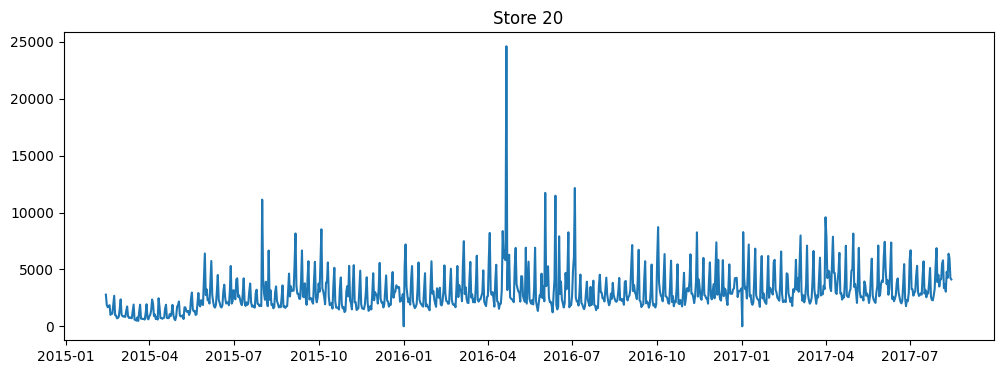

In [104]:
exploration_df_cleaned = df_beverages_cleaned_no_gaps[
    df_beverages_cleaned_no_gaps["store_nbr"].isin(explore_store_nbrs)
]
plot_sales(exploration_df_cleaned)

## 5. Interpolate Missing Values

In [86]:
def interpolate_missing(group: pd.DataFrame) -> pd.DataFrame:
    group = group.sort_values("date").reset_index(drop=True)
    group["sales"] = group["sales"].interpolate(method="linear", limit_direction="both")
    return group

In [87]:
df_beverages_interpolated = df_beverages_cleaned_no_gaps.groupby(
    ["store_nbr", "family"]
).apply(interpolate_missing, include_groups=False)
df_beverages_interpolated = df_beverages_interpolated.reset_index(
    level=["store_nbr", "family"]
)

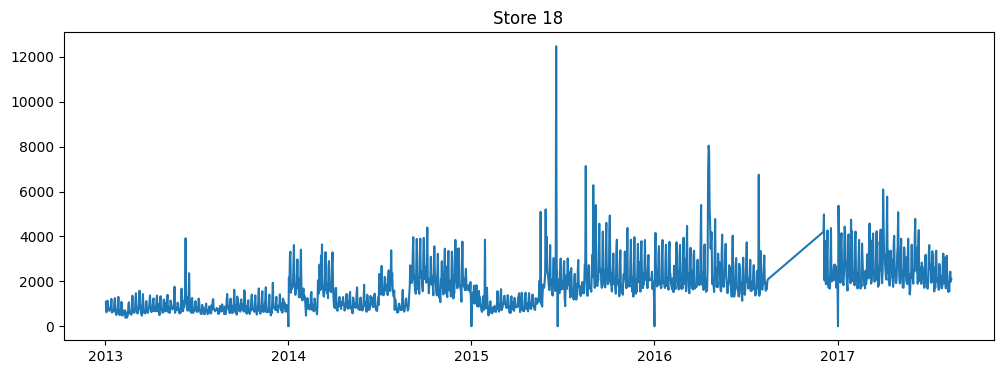

In [89]:
explore_store_nbrs = [18]
exploration_df_interpolated = df_beverages_interpolated[
    df_beverages_interpolated["store_nbr"].isin(explore_store_nbrs)
]
plot_sales(exploration_df_interpolated)

## 6. Process && Save All Store-Family Pairs

In [ ]:
def process_store_family_pairs(data_df: pd.DataFrame) -> pd.DataFrame:
    ...

def save_store_family_pairs(data_df: pd.DataFrame) -> None:
    ...